In [1]:
# -*- coding: utf-8 -*-
import time
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

c:\Users\Davidgu\anaconda3\envs\tensorflow-cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://huggingface.co/datasets/thuml/UTSD
# https://github.com/thuml/Large-Time-Series-Model/tree/main

ds = datasets.load_dataset("thuml/UTSD", "UTSD-1G")
# ds = datasets.load_dataset("thuml/UTSD", "UTSD-2G")
# ds = datasets.load_dataset("thuml/UTSD", "UTSD-4G")
# ds = datasets.load_dataset("thuml/UTSD", "UTSD-12G")

all = ds["train"]
print(f'total {len(all)} single-variate series')
print(all[0].keys())

for k, v in all[0].items():
    print(f'{k}: {type(v)}')
    if k == 'target':
        print(f'    {v[:10]}')
    else:
        print(f'    {v}')

total 68679 single-variate series
dict_keys(['item_id', 'start', 'end', 'freq', 'target'])
item_id: <class 'str'>
    Health_SelfRegulationSCP1_458_0
start: <class 'str'>
    
end: <class 'str'>
    
freq: <class 'str'>
    
target: <class 'list'>
    [-8.119999885559082, -11.5600004196167, -14.279999732971191, -18.190000534057617, -20.030000686645508, -20.84000015258789, -20.09000015258789, -19.5, -18.059999465942383, -17.25]


In [3]:
# energy - wind farm : 68547
data = all[68547]['target']
data_len = len(data)
df_Energy_wind = pd.DataFrame({"points":list(range(data_len)),"Power(kW)":data})
df_Energy_wind.head()

,points,Power(kW)
0,0,18.6
1,1,18.6
2,2,18.6
3,3,18.6
4,4,18.6


## Moving Average to denoise data

In [4]:
# 5 點移動平均（預設右端對齊）
df_Energy_wind['moving_ave_5'] = (
    df_Energy_wind['Power(kW)']
    .rolling(window=5,   # 視窗長度 5 筆
             min_periods=1)  # 前幾筆不足 5 也先算平均，避免 NaN
    .mean()
)


# 10 點移動平均（預設右端對齊）
df_Energy_wind['moving_ave_10'] = (
    df_Energy_wind['Power(kW)']
    .rolling(window=10,
             min_periods=1)
    .mean()
)



# 20 點移動平均（預設右端對齊）
df_Energy_wind['moving_ave_20'] = (
    df_Energy_wind['Power(kW)']
    .rolling(window=20,
             min_periods=1)
    .mean()
)

In [5]:
# 定義上下文區間
window_size = 50
stride = 2
max_point = 28000

#訓練參數
p, d, q   = 5, 1, 0

#存檔參數
model_name = f"arima_energyfarm_0618"

In [6]:
# 定義資料範圍
data_samples = np.array(df_Energy_wind['moving_ave_20'].to_list()[:max_point])

In [7]:
# 切分訓練 / 驗證
split = int(len(data_samples)*0.8)
train, test = data_samples[:split], data_samples[split:]

print(f"train.shape, test.shape = {train.shape}, {test.shape}")

train.shape, test.shape = (22400,), (5600,)


In [8]:
# 用訓練集擬合一次
model = ARIMA(train, order=(p,d,q))
res   = model.fit()

## Multi-step forcast

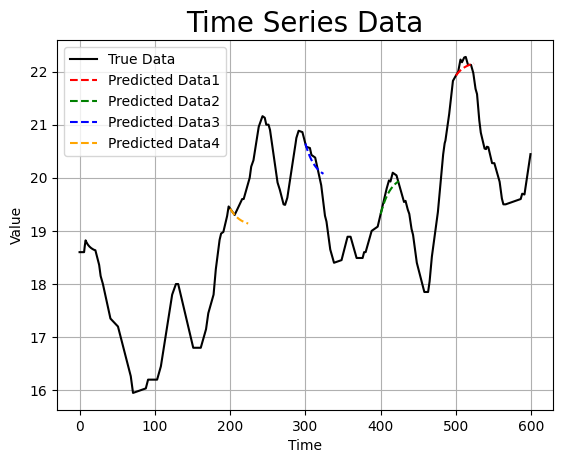

In [9]:
# 每一次重新fit
def fit_and_autoregressive_forecast(window, n_steps):
    _window = window.copy()
    _model = ARIMA(_window, order=(p,d,q))
    _res = _model.fit()
    _preds = _res.forecast(steps=n_steps)
    return np.array(_preds)


# 使用原先的 res 進行fit
def autoregressive_forecast(window, n_steps):
    # 確保有時間索引
    window = pd.Series(window)
    # 用 res.apply(...) 把現有參數套到這段資料
    res_new = res.apply(window, refit=False)
    # 一次預測n點
    preds = res_new.forecast(steps=n_steps)
    return np.array(preds)


# prediction
n_steps = 25
org_test_samples = np.array(df_Energy_wind['moving_ave_20'][:600])
test_samples_1 = org_test_samples[:500]
preds1 = autoregressive_forecast(test_samples_1, n_steps=n_steps)

test_samples_2 = org_test_samples[:400]
preds2 = autoregressive_forecast(test_samples_2, n_steps=n_steps)

test_samples_3 = org_test_samples[:300]
preds3 = autoregressive_forecast(test_samples_3, n_steps=n_steps)

test_samples_4 = org_test_samples[:200]
preds4 = autoregressive_forecast(test_samples_4, n_steps=n_steps)

# 繪製模擬資料+預測資料 PS:迴歸模型普遍現象: 誤差逐步累積
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(range(len(org_test_samples)),org_test_samples, label='True Data',c='black')
plt.plot(range(len(test_samples_1),len(test_samples_1)+n_steps), preds1, label='Predicted Data1',c='red', linestyle='--')
plt.plot(range(len(test_samples_2),len(test_samples_2)+n_steps), preds2, label='Predicted Data2',c='green', linestyle='--')
plt.plot(range(len(test_samples_3), len(test_samples_3)+n_steps), preds3, label='Predicted Data3', c='blue', linestyle='--')
plt.plot(range(len(test_samples_4), len(test_samples_4)+n_steps), preds4, label='Predicted Data4', c='orange', linestyle='--')
plt.legend(fontsize=10)
plt.show()

## preds on testing data

In [10]:
# walk-forward：逐點預測，再把真值 append 進來更新狀態
preds = []
res_stream = res
for y_true in test:
    y_hat = res_stream.forecast(steps=1)[0]   # 只花 O(1) 時間
    preds.append(y_hat)

    # 把新觀測附加進模型狀態；refit=False 表示 **不重新估計參數**
    res_stream = res_stream.append([y_true], refit=False)

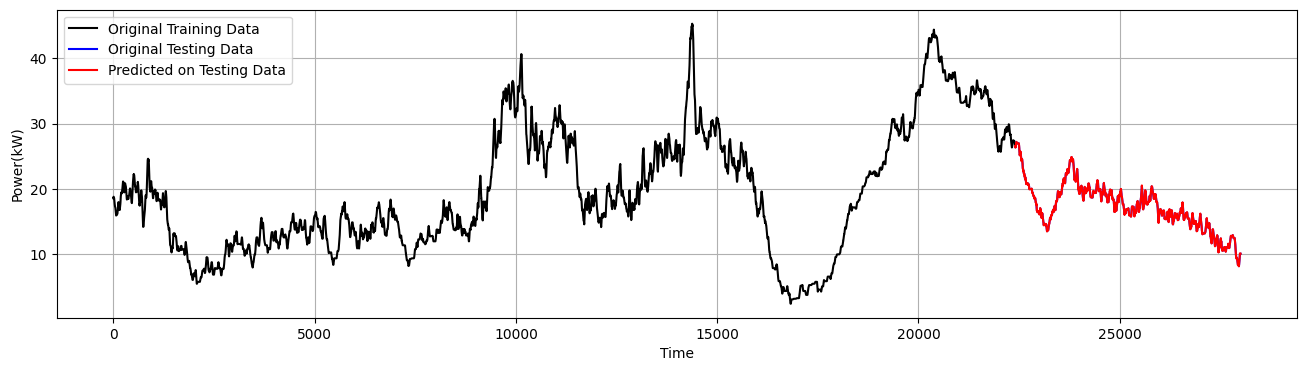

In [11]:
# 繪製模擬資料+預測資料
plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Power(kW)')
plt.plot(range(len(train)),train, label='Original Training Data',c='black')
plt.plot(range(len(train),len(train)+len(test)),test, label='Original Testing Data',c='blue')
plt.plot(range(len(train),len(train)+len(test)), preds, label='Predicted on Testing Data',c='red')
plt.legend(fontsize=10,loc='upper left')
plt.show()

## Compute Score

In [12]:
# 計算各項分數
def compute_mae(y_true, y_pred):
    _y_pred = np.asarray(y_pred, dtype=float)
    _y_true = np.asarray(y_true, dtype=float)
    mae = mean_absolute_error(_y_true, _y_pred)
    # mae = np.mean(np.abs(_y_true - _y_pred))
    return mae

def compute_rmse(y_true, y_pred):
    _y_pred = np.asarray(y_pred, dtype=float)
    _y_true = np.asarray(y_true, dtype=float)
    rmse = np.sqrt(mean_squared_error(_y_true, _y_pred))
    return rmse


def compute_r2(y_true, y_pred):
    _y_pred = np.asarray(y_pred, dtype=float)
    _y_true = np.asarray(y_true, dtype=float)
    r2 = r2_score(_y_true, _y_pred)
    return r2

In [13]:
# Testing Data Score
mae_test = compute_mae(test, preds)
rmse_test = compute_rmse(test, preds)
r2_test = compute_r2(test, preds)

print(f"Testing Data Score: MAE = {mae_test:.4f}, RMSE = {rmse_test:.4f}, R² = {r2_test:.4f}")

Testing Data Score: MAE = 0.0084, RMSE = 0.0193, R² = 1.0000


## Print & Export Params

In [14]:
res.params

array([ 9.67875404e-01, -2.53698284e-02, -1.56736102e-02,  3.40321853e-02,
       -2.74003876e-02,  5.90725635e-04])

In [15]:
res.param_names

['ar.L1', 'ar.L2', 'ar.L3', 'ar.L4', 'ar.L5', 'sigma2']

In [16]:
res.arparams

array([ 0.9678754 , -0.02536983, -0.01567361,  0.03403219, -0.02740039])

In [17]:
res.maparams

array([], dtype=float64)

In [18]:
res.resid

array([ 1.86000004e+01, -8.49373158e-08,  3.59062113e-10, ...,
       -2.99412939e-03, -2.99412939e-03, -2.99412939e-03])

In [19]:
# 匯出權重: 將必要資訊寫進 model.csv
param_dict = dict(zip(res.param_names, res.params))
mu = param_dict.get('const', 0.0)      # 沒截距時預設 0

out = {
    "order_p": p,
    "order_d": d,
    "order_q": q,
    "mu":      mu,                     # 截距
    "sigma2":  param_dict['sigma2'],      # 噪音變異
    # AR 係數 φ1…φp
    **{f"phi{i+1}": v for i, v in enumerate(res.arparams)},
    # MA 係數 θ1…θq
    **{f"theta{j+1}": v for j, v in enumerate(res.maparams)},
    # 最後 q 個殘差，用來做多步預測
    **{f"eps{j+1}": v for j, v in enumerate(res.resid[-q:][::-1])}
}
pd.Series(out).to_csv("./checkpoints/arima/model.csv", header=False)

In [20]:
# 匯出預測數據
pd.Series(test_samples_2).to_csv("./checkpoints/arima/input.csv", header=False, index=False)
print(preds2)

[19.31567669 19.3688697  19.41839891 19.46451277 19.50730572 19.5470625
 19.58396175 19.61820853 19.64998869 19.6794812  19.70684967 19.73224704
 19.75581512 19.7776857  19.79798101 19.81681452 19.8342915  19.85050967
 19.86555969 19.8795257  19.89248578 19.90451238 19.91567274 19.92602925
 19.93563981]


In [21]:
# 讀取C++預測的結果
preds2_cpp = []
with open("./checkpoints/arima/output.csv", 'r') as f:
    for line in f:
        preds2_cpp.append(float(line.strip()))
print(preds2_cpp)

[19.3157, 19.3689, 19.4184, 19.4645, 19.5073, 19.5471, 19.584, 19.6182, 19.65, 19.6795, 19.7068, 19.7322, 19.7558, 19.7777, 19.798, 19.8168, 19.8343, 19.8505, 19.8656, 19.8795, 19.8925, 19.9045, 19.9157, 19.926, 19.9356]


## Comparison between C++ and Python

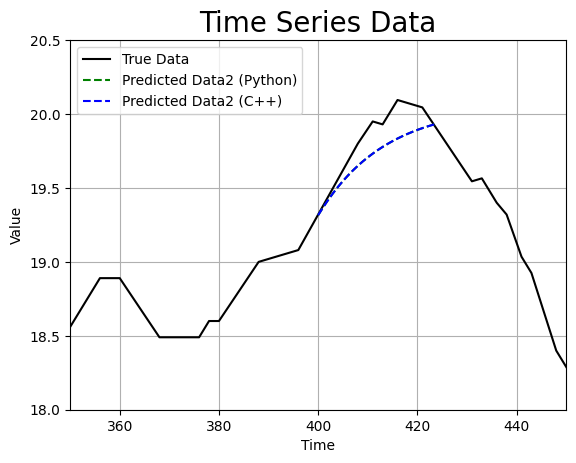

In [22]:
# 繪製C++預測的結果
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(range(len(org_test_samples)),org_test_samples, label='True Data',c='black')
plt.plot(range(len(test_samples_2),len(test_samples_2)+n_steps), preds2, label='Predicted Data2 (Python)',c='green', linestyle='--')
plt.plot(range(len(test_samples_2), len(test_samples_2)+n_steps), preds2_cpp, label='Predicted Data2 (C++)', c='blue', linestyle='--')
# 設定軸範圍
plt.xlim(350, 450)
plt.ylim(18, 20.5)

plt.legend(fontsize=10, loc='upper left')
plt.show()

In [23]:
# 匯出預測數據-2
pd.Series(test_samples_3).to_csv("./checkpoints/arima/input-2.csv", header=False, index=False)
print(preds3)

[20.64399123 20.59514364 20.54965665 20.5073049  20.46800438 20.43148905
 20.39759803 20.36614315 20.33695386 20.30986561 20.28472825 20.2614013
 20.23975451 20.21966684 20.20102601 20.18372783 20.16767559 20.15277954
 20.13895641 20.12612892 20.11422535 20.10317917 20.09292861 20.08341637
 20.07458927]


In [24]:
# 讀取C++預測的結果
preds3_cpp = []
with open("./checkpoints/arima/output-2.csv", 'r') as f:
    for line in f:
        preds3_cpp.append(float(line.strip()))
print(preds3_cpp)

[20.644, 20.5951, 20.5497, 20.5073, 20.468, 20.4315, 20.3976, 20.3661, 20.337, 20.3099, 20.2847, 20.2614, 20.2398, 20.2197, 20.201, 20.1837, 20.1677, 20.1528, 20.139, 20.1261, 20.1142, 20.1032, 20.0929, 20.0834, 20.0746]


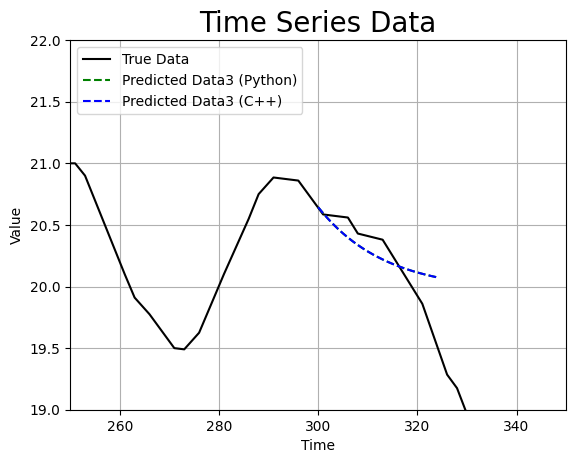

In [25]:
# 繪製C++預測的結果
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data', fontsize=20)
plt.plot(range(len(org_test_samples)),org_test_samples, label='True Data',c='black')
plt.plot(range(len(test_samples_3),len(test_samples_3)+n_steps), preds3, label='Predicted Data3 (Python)',c='green', linestyle='--')
plt.plot(range(len(test_samples_3), len(test_samples_3)+n_steps), preds3_cpp, label='Predicted Data3 (C++)', c='blue', linestyle='--')
# 設定軸範圍
plt.xlim(250, 350)
plt.ylim(19, 22)

plt.legend(fontsize=10, loc='upper left')
plt.show()